<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials/blob/main/Tutorial13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorboard**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

* library for tensorboard

In [2]:
import os
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mist1')

# device, hyper-parameters

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 784 # 28*28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

# dataset MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



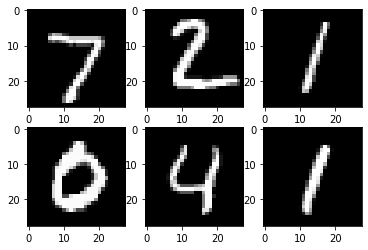

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

example = iter(test_loader)
example_data, example_targets = next(example)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# fully connected netral network with one hidden layer

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [6]:
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# tensorboard

In [ ]:
writer.add_graph(model, example_data.reshape(-1,28*28).to(device))

# train model

In [10]:
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # origin shape: [100,1,28,28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct +=(predicted == labels).sum().item()
        if(i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # tensorboard
            writer.add_scalar('training loss', running_loss/100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0

Epoch [1/1], Step [100/938], Loss: 0.2717
Epoch [1/1], Step [200/938], Loss: 0.2049
Epoch [1/1], Step [300/938], Loss: 0.1836
Epoch [1/1], Step [400/938], Loss: 0.2194
Epoch [1/1], Step [500/938], Loss: 0.1098
Epoch [1/1], Step [600/938], Loss: 0.1236
Epoch [1/1], Step [700/938], Loss: 0.2468
Epoch [1/1], Step [800/938], Loss: 0.1451
Epoch [1/1], Step [900/938], Loss: 0.2159


# test the model

* In test phase, we don't need to compute gradients (for memory efficiency)

In [11]:
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(labels)

    # 10000, 10 and 10000, 1 stack concatinates tensor along a new dimension
    # cat concatinates tensor in the given dimension
    class_pred = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc =  100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.24 %


* tensorboard

In [13]:
classes = range(10)
for i in classes:
    labels_i = class_labels == i
    preds_i = class_pred[:, i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.close()